In [12]:
import json
import pandas as pd
import numpy as np
import random
import modules.gnrl as gnrl
import modules.LP_Pool_State as lpps
import datetime
import seaborn as sns


In [13]:
with open("config.json", 'r') as f:
    args = json.load(f)
with open("MP_ASSET_STATE.csv","r") as outfile:
    MP_Asset_State = pd.read_csv(outfile, index_col=0)
with open("MP_ASSET.csv","r") as outfile:
    MP_Asset = pd.read_csv(outfile, index_col=0)

LS_Opening = pd.read_csv("LS_Opening.csv ",index_col=0)
LP_Deposit = pd.read_csv("LP_Deposit.csv",index_col=0)
#LP_Withdraw = pd.read_csv("LP_Withdraw",index_col=0)

#LS_Repayment = pd.read_csv("LS_Repayment",index_col=0)
#LS_Closing = pd.read_csv("LS_Closing_p2",index_col=0)
#LS_Liquidation = pd.read_csv("LS_Liquidation",index_col=0)




array([[<AxesSubplot:title={'center':'SYS_LS_expected_payment'}>]],
      dtype=object)

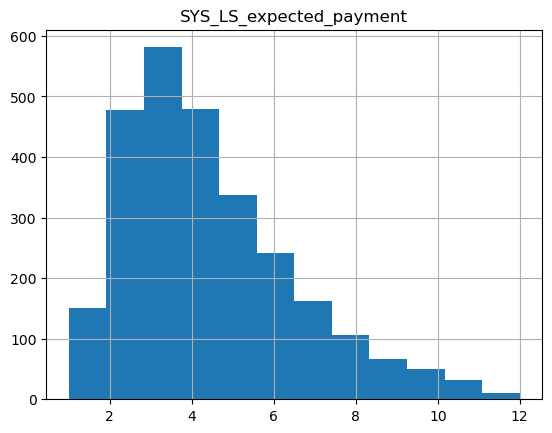

In [15]:
LS_Opening.hist(column="SYS_LS_expected_payment",bins=12)



array([[<AxesSubplot:title={'center':'SYS_LS_expected_penalty'}>]],
      dtype=object)

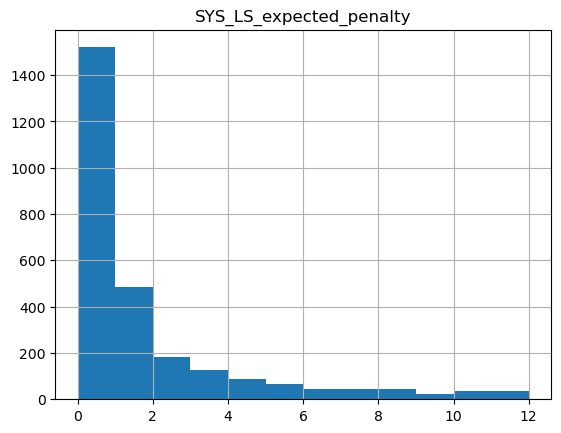

In [18]:
LS_Opening.hist(column="SYS_LS_expected_penalty",bins=12)


array([[<AxesSubplot:title={'center':'LS_loan_amnt_stable'}>]],
      dtype=object)

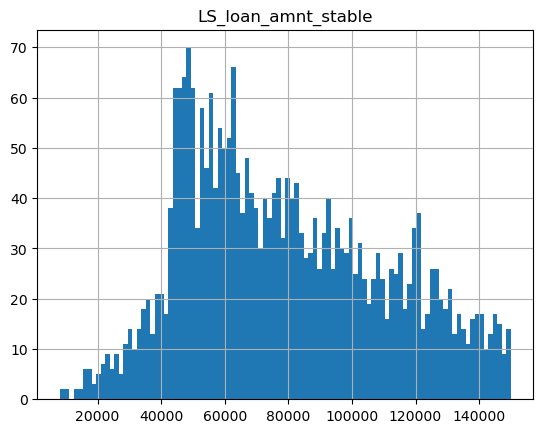

In [24]:
LS_Opening.hist(column="LS_loan_amnt_stable",bins=100)


array([[<AxesSubplot:title={'center':'LP_amnt_stable'}>]], dtype=object)

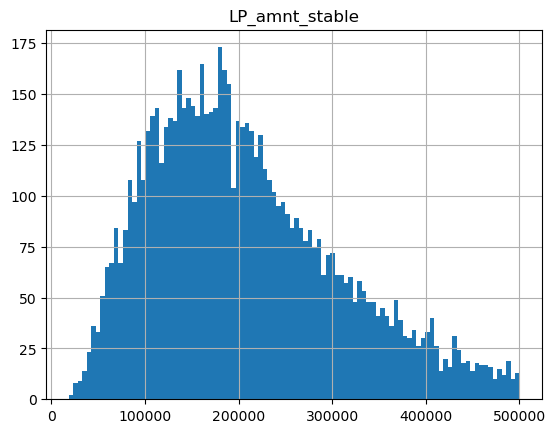

In [27]:
LP_Deposit.hist(column="LP_amnt_stable",bins=100)


array([[<AxesSubplot:title={'center':'SYS_LP_expected_duration'}>]],
      dtype=object)

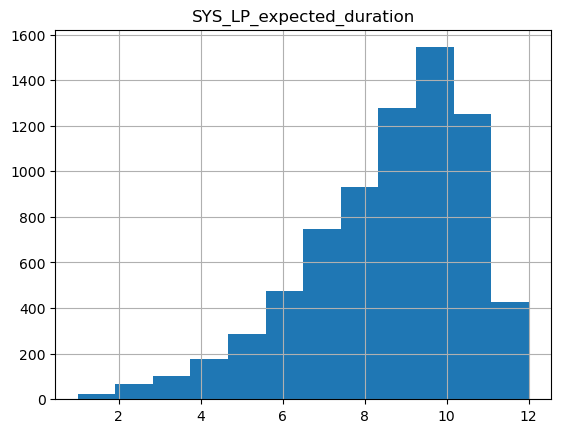

In [28]:
LP_Deposit.hist(column="SYS_LP_expected_duration",bins=12)


In [25]:
LP_Deposit

,LP_address_id,LP_deposit_height,LP_deposit_idx,LP_Pool_id,LP_amnt_asset,LP_amnt_stable,SYS_LP_expected_duration,SYS_LP_contract_id,SYS_end_date
LP_timestamp,,,,,,,,,
2021-01-12,lpaid1000000,100,100,pid101,149719,151558,10,lpaid1000000100,2021-11-08
2021-01-13,lpaid1000001,101,101,pid101,82483,82928,6,lpaid1000001101,2021-07-12
2021-01-13,lpaid1000002,102,102,pid101,191252,192284,10,lpaid1000002102,2021-11-09
2021-01-14,lpaid1000003,103,103,pid100,190924,190924,10,lpaid1000003103,2021-11-10
2021-01-14,lpaid1000004,104,104,pid100,120835,120835,11,lpaid1000004104,2021-12-10
...,...,...,...,...,...,...,...,...,...
2023-01-11,lpaid1007303,7403,7403,pid100,264811,264811,12,lpaid10073037403,2024-01-06
2023-01-11,lpaid1007304,7404,7404,pid100,187376,187376,7,lpaid10073047404,2023-08-09
2023-01-11,lpaid1007305,7405,7405,pid100,185591,185591,12,lpaid10073057405,2024-01-06


In [5]:
def LP_Deposit_Generate(MP_Asset,pool_id,args):
    names=["LP_asset_symbol","LP_timestamp","LP_address_id","LP_deposit_height"]
    id_prefix = ["lpaid","lpcid"]
    LP_Deposit = gnrl.timestamps_generation(MP_Asset,names,id_prefix,args["new_LP_opened_daily_count"],args)
    lp_dep_h = [s for s in range(100,100+len(LP_Deposit))]
    lp_dep_idx = lp_dep_h
    LP_Deposit = LP_Deposit.drop(["LP_asset_symbol"],axis=1)
    
    LP_Deposit["LP_deposit_height"] = lp_dep_h
    LP_Deposit["LP_deposit_idx"] = lp_dep_idx
    np.random.seed(args["seed"])
    args["seed"] = args["seed"]+1
    lp_list = np.random.choice(args["Pool_Assets"],len(LP_Deposit))
    LP_Deposit["LP_symbol"] = lp_list
    pool_id.rename(columns={"LS_loan_pool_id":"LP_pool_id"})
    LP_Deposit = pd.merge(LP_Deposit,pool_id,on="LP_symbol",how="left")
    LP_Deposit["LP_amnt_asset"] = gnrl.f_dist(args["LP_amnt_stable_df_num"],
                        args["LP_amnt_stable_df_den"],
                        args["LP_amnt_stable_min"],
                        args["LP_amnt_stable_max"],
                        len(LP_Deposit),args,args["LP_multiplyer"])
     
    LP_Deposit["LP_amnt_asset"]= LP_Deposit["LP_amnt_asset"].round(0).astype("uint64")
    symbol_digit = pd.DataFrame(args["symbol_digit"])
    symbol_digit = symbol_digit.rename(columns={"symbol":"LP_symbol"})
    LP_Deposit = pd.merge(LP_Deposit,symbol_digit,on = "LP_symbol",how='left')
    MP_Asset = MP_Asset.rename(columns={"MP_timestamp":"LP_timestamp","MP_asset_symbol":"LP_symbol"})
    LP_Deposit = pd.merge(LP_Deposit,MP_Asset,on=["LP_timestamp","LP_symbol"],how='left')
    
    LP_Deposit["LP_amnt_asset"] = LP_Deposit["LP_amnt_asset"].multiply(10**LP_Deposit["digit"]).astype("uint64")
    LP_Deposit["MP_price_in_stable"] = LP_Deposit["MP_price_in_stable"].div(10**LP_Deposit["digit"])
    LP_Deposit.loc[(LP_Deposit["LP_symbol"] == args["currency_stable"]),'MP_price_in_stable']=1
    
    LP_Deposit["LP_amnt_stable"] = LP_Deposit["LP_amnt_asset"]*LP_Deposit["MP_price_in_stable"]

    LP_Deposit["LP_amnt_stable"] = LP_Deposit["LP_amnt_stable"].round(0).astype("uint64")
    LP_Deposit = LP_Deposit.drop(["digit","MP_price_in_stable","LP_symbol"],axis=1)
    
    LP_Deposit["SYS_LP_expected_duration"] = gnrl.f_dist(args["LS_loan_amnt_asset_df_num"],
                                                    args["LS_loan_amnt_asset_df_den"],
                                                    args["SYS_LS_expected_payment_min"],
                                                    args["SYS_LS_expected_payment_max"], len(LP_Deposit),
                                                    args, args["SYS_LS_expected_payment_extremum"])
    LP_Deposit["SYS_LP_expected_duration"] = LP_Deposit["SYS_LP_expected_duration"] - 13
    LP_Deposit["SYS_LP_expected_duration"] = LP_Deposit["SYS_LP_expected_duration"]*-1
    LP_Deposit["SYS_LP_expected_duration"] = LP_Deposit["SYS_LP_expected_duration"].round(0).astype(int)
    LP_Deposit["SYS_LP_contract_id"] = LP_Deposit["LP_address_id"] + LP_Deposit["LP_deposit_idx"].astype(str)
    #LP_Depo
    return LP_Deposit
pool_id = lpps.LP_pool_gen(args)
LP_Deposit = LP_Deposit_Generate(MP_Asset,pool_id,args)
#LP_Deposit = LP_Deposit_Generate(MP_Asset,pool_id,args)


    

421

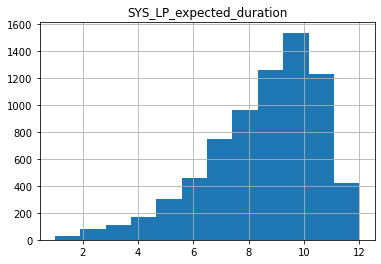

In [6]:
LP_Deposit.hist("SYS_LP_expected_duration",bins=12)
(LP_Deposit["SYS_LP_expected_duration"]>=12).sum()


In [8]:
LP_Deposit

,LP_timestamp,LP_address_id,LP_deposit_height,LP_deposit_idx,LP_Pool_id,LP_amnt_asset,LP_amnt_stable,SYS_LP_expected_duration,SYS_LP_contract_id
0,2020-08-22 03:00:00,lpaid1000000,100,100,pid100,27715000000000000,27715000000000000,11,lpaid1000000100
1,2020-08-23 03:00:00,lpaid1000001,101,101,pid101,9845000000000000,9842657153304526,12,lpaid1000001101
2,2020-08-23 03:00:00,lpaid1000002,102,102,pid100,16312000000000000,16312000000000000,11,lpaid1000002102
3,2020-08-24 03:00:00,lpaid1000003,103,103,pid100,31787000000000000,31787000000000000,10,lpaid1000003103
4,2020-08-24 03:00:00,lpaid1000004,104,104,pid100,10153000000000000,10153000000000000,9,lpaid1000004104
...,...,...,...,...,...,...,...,...,...
7303,2022-08-21 03:00:00,lpaid1007303,7403,7403,pid100,22705000000000000,22705000000000000,12,lpaid10073037403
7304,2022-08-21 03:00:00,lpaid1007304,7404,7404,pid101,32498000000000000,32515995380026344,7,lpaid10073047404
7305,2022-08-21 03:00:00,lpaid1007305,7405,7405,pid101,18243000000000000,18253101843738712,12,lpaid10073057405
7306,2022-08-21 03:00:00,lpaid1007306,7406,7406,pid101,22516000000000000,22528467966541732,5,lpaid10073067406


In [1]:
LS_Closing

NameError: name 'LS_Closing' is not defined

In [10]:
def lpw_timestamp(LP_Deposit,basis,args):
    day = 86400
    month = 30*day
    if basis == "month":
        duration = LP_Deposit["SYS_LP_expected_duration"].values
        timestamp = pd.DataFrame({"LP_timestamp":LP_Deposit["LP_timestamp"],"LP_address_id":LP_Deposit["LP_address_id"],"SYS_LP_contract_id":LP_Deposit["SYS_LP_contract_id"]})
        timestamp["LP_timestamp"] = LP_Deposit["LP_timestamp"].astype("datetime64").apply(lambda x:datetime.datetime.timestamp(x)).astype(int)
        timestamp["LP_Pool_id"] = LP_Deposit["LP_Pool_id"]
        #print(type(timestamp["LP_"][0]))    
        #timestamp = np.repeat(timestamp.values, duration+1, axis=0)
        #timestamp = pd.DataFrame(timestamp.values)
        timestamp = pd.DataFrame(np.repeat(timestamp.values, duration, axis=0))
        timestamp = pd.DataFrame({"LP_timestamp":timestamp[0],"LP_address_id":timestamp[1],"SYS_LP_contract_id":timestamp[2],"LP_Pool_id":timestamp[3]})
        timestamp["LP_timestamp"] = timestamp["LP_timestamp"].values.astype("uint64")
        #duration = pd.DataFrame({"duration":duration})
        d = []
        l1 = []
        for i in duration:
            l1 = [s for s in range(1,i+1)]
            d.extend(l1)
        timestamp["Duration"] = d 
        timestamp["Duration"] = timestamp["Duration"]*month
        timestamp["LP_timestamp"] = timestamp["LP_timestamp"]+timestamp["Duration"]
        timestamp["LP_timestamp"] = timestamp["LP_timestamp"].apply(datetime.datetime.fromtimestamp)
        timestamp = timestamp.drop("Duration",axis=1)
    if basis == "day":
        duration = LP_Deposit["SYS_LP_expected_duration"].values
        duration = duration*30
        print(len(duration))
        timestamp = pd.DataFrame({"LP_timestamp":LP_Deposit["LP_timestamp"],"LP_address_id":LP_Deposit["LP_address_id"],"SYS_LP_contract_id":LP_Deposit["SYS_LP_contract_id"]})
        timestamp["LP_timestamp"] = LP_Deposit["LP_timestamp"].astype("datetime64").apply(lambda x:datetime.datetime.timestamp(x)).astype(int)
        timestamp["LP_Pool_id"] = LP_Deposit["LP_Pool_id"]
        #print(type(timestamp["LP_"][0]))    
        #timestamp = np.repeat(timestamp.values, duration+1, axis=0)
        #timestamp = pd.DataFrame(timestamp.values)
        timestamp = pd.DataFrame(np.repeat(timestamp.values, duration, axis=0))
        timestamp = pd.DataFrame({"LP_timestamp":timestamp[0],"LP_address_id":timestamp[1],"SYS_LP_contract_id":timestamp[2],"LP_Pool_id":timestamp[3]})
        timestamp["LP_timestamp"] = timestamp["LP_timestamp"].values.astype("uint64")
        #duration = pd.DataFrame({"duration":duration})
        d = []
        l1 = []
        for i in duration:
            l1 = [s for s in range(1,i+1)]
            d.extend(l1)
        timestamp["Duration"] = d 
        timestamp["Duration"] = timestamp["Duration"]*day
        timestamp["LP_timestamp"] = timestamp["LP_timestamp"]+timestamp["Duration"]
        timestamp["LP_timestamp"] = timestamp["LP_timestamp"].apply(datetime.datetime.fromtimestamp)
        timestamp = timestamp.drop("Duration",axis=1)
    
    return timestamp

def LP_Withdraw_generate(LP_Deposit,pool_id,args):
    

    LP_Withdraw = pd.DataFrame(lpw_timestamp(LP_Deposit,"month",args))
    lp_dep_h = [s for s in range(100,100+len(LP_Withdraw))]
    lp_dep_idx = lp_dep_h
    LP_Withdraw["LP_withdraw_height"] = lp_dep_h
    LP_Withdraw["LP_withdraw_idx"] = lp_dep_idx
    #withdraw = Deposit*expected_duration, last means it gets closed in the end of the duration
    #generated rows could be later used for change in the ammount during the expected_duration
    SYS_LP_Withdraw = pd.DataFrame(lpw_timestamp(LP_Deposit,"day",args))
    lp_dep_h = [s for s in range(100,100+len(SYS_LP_Withdraw))]
    lp_dep_idx = lp_dep_h
    SYS_LP_Withdraw["LP_withdraw_height"] = lp_dep_h
    SYS_LP_Withdraw["LP_withdraw_idx"] = lp_dep_idx
    
    LP_Withdraw = LP_Withdraw.drop_duplicates(subset=["LP_address_id"],keep="last",ignore_index=True)
    LP_Withdraw["LP_deposit_close"] = True
    SYS_LP_Withdraw[["LP_amnt_stable","LP_interest","LP_interest_amnt"]] = 0
    LP_Withdraw["LP_amnt_stable"] = 0

    
    return LP_Withdraw, SYS_LP_Withdraw
wit,sys_wit = LP_Withdraw_generate(LP_Deposit,pool_id,args)

7308


In [11]:
wit.to_csv("LP_Withdraw")
LP_Deposit.to_csv("LP_Deposit")
sys_wit.to_csv("SYS_LP_Withdraw")

In [12]:
sys_wit

,LP_timestamp,LP_address_id,SYS_LP_contract_id,LP_Pool_id,LP_withdraw_height,LP_withdraw_idx,LP_amnt_stable,LP_interest,LP_interest_amnt
0,2020-08-23 03:00:00,lpaid1000000,lpaid1000000100,pid100,100,100,0,0,0
1,2020-08-24 03:00:00,lpaid1000000,lpaid1000000100,pid100,101,101,0,0,0
2,2020-08-25 03:00:00,lpaid1000000,lpaid1000000100,pid100,102,102,0,0,0
3,2020-08-26 03:00:00,lpaid1000000,lpaid1000000100,pid100,103,103,0,0,0
4,2020-08-27 03:00:00,lpaid1000000,lpaid1000000100,pid100,104,104,0,0,0
...,...,...,...,...,...,...,...,...,...
1910755,2023-03-15 02:00:00,lpaid1007307,lpaid10073077407,pid100,1910855,1910855,0,0,0
1910756,2023-03-16 02:00:00,lpaid1007307,lpaid10073077407,pid100,1910856,1910856,0,0,0
1910757,2023-03-17 02:00:00,lpaid1007307,lpaid10073077407,pid100,1910857,1910857,0,0,0
1910758,2023-03-18 02:00:00,lpaid1007307,lpaid10073077407,pid100,1910858,1910858,0,0,0


In [207]:
def add_hyperparameter(Name,Data):
    with open("config.json", 'r') as f:
        args = json.load(f)
    for n in Name:
        for d in Data:
            args[""+n+""] = d
            break
    with open("config.json", 'w') as f:
        json.dump(args,f)
    return

In [31]:
add_hyperparameter(["LP_amnt_stable_df_num","LP_amnt_stable_df_den","LP_amnt_stable_min","LP_amnt_stable_max","LP_multiplyer"],[10,20,100,50000,20000])

In [208]:
add_hyperparameter(["LP_amnt_stable_df_num"],[10])
add_hyperparameter(["LP_amnt_stable_df_den"],[20])
add_hyperparameter(["LP_amnt_stable_min"],[100])
add_hyperparameter(["LP_amnt_stable_max"],[15000])
add_hyperparameter(["LP_multiplyer"],[20000])

In [33]:
args

{'N': 731,
 'new_LS_opened_type': 'function',
 'new_LS_opened_daily_count': 'tf.csv',
 'Active_Assets': ['bitcoin',
  'wrapped-bitcoin',
  'ethereum',
  'kava',
  'usd-coin',
  'tether',
  'dai',
  'cosmos',
  'crypto-com-chain',
  'cardano',
  'ripple',
  'solana',
  'dogecoin',
  'matic-network'],
 'Active_Assets_Distribution': [0.3,
  0.06,
  0.15,
  0.04,
  0.03,
  0.04,
  0.03,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 'Pool_Assets': ['usd-coin', 'tether'],
 'seed': 32,
 'LS_loan_amnt_asset_df_num': 10,
 'LS_loan_amnt_asset_df_den': 20,
 'LS_loan_amnt_asset_min': 0.1,
 'LS_loan_amnt_asset_max': 3,
 'LS_cltr_amnt_asset_min': 1,
 'LS_cltr_amnt_asset_max': 1.5,
 'SYS_LS_expected_penalty_df_num': 1,
 'SYS_LS_expected_penalty_df_den': 1,
 'SYS_LS_expected_payment_min': 1,
 'SYS_LS_expected_payment_max': 12,
 'SYS_LS_expected_payment_extremum': 4,
 'SYS_LS_expected_penalty_min': 0,
 'SYS_LS_expected_penalty_max': 12,
 'id_generator': 'series',
 'method': 'range_normaliza

In [69]:
sys.max()

NameError: name 'sys' is not defined

In [70]:
import sys 

In [73]:
len(str(sys.maxsize))

19

In [97]:
args


{'N': 731,
 'new_LS_opened_type': 'function',
 'new_LS_opened_daily_count': 'tf.csv',
 'Active_Assets': ['bitcoin',
  'wrapped-bitcoin',
  'ethereum',
  'kava',
  'usd-coin',
  'tether',
  'dai',
  'cosmos',
  'crypto-com-chain',
  'cardano',
  'ripple',
  'solana',
  'dogecoin',
  'matic-network'],
 'Active_Assets_Distribution': [0.3,
  0.06,
  0.15,
  0.04,
  0.03,
  0.04,
  0.03,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 'Pool_Assets': ['usd-coin', 'tether'],
 'seed': 32,
 'LS_loan_amnt_asset_df_num': 10,
 'LS_loan_amnt_asset_df_den': 20,
 'LS_loan_amnt_asset_min': 0.1,
 'LS_loan_amnt_asset_max': 3,
 'LS_cltr_amnt_asset_min': 1,
 'LS_cltr_amnt_asset_max': 1.5,
 'SYS_LS_expected_penalty_df_num': 1,
 'SYS_LS_expected_penalty_df_den': 1,
 'SYS_LS_expected_payment_min': 1,
 'SYS_LS_expected_payment_max': 12,
 'SYS_LS_expected_payment_extremum': 4,
 'SYS_LS_expected_penalty_min': 0,
 'SYS_LS_expected_penalty_max': 12,
 'id_generator': 'series',
 'method': 'range_normaliza

In [89]:
x = pd.DataFrame({"x":[10000*(10**15)]}).astype("uint64")

In [90]:
args[]

,x
0,10000000000000000000


In [12]:
sys_wit

,LP_timestamp,LP_address_id,LP_Pool_id,LP_withdraw_height,LP_withdraw_idx,LP_amnt_stable,LP_interest,LP_interest_amnt
0,2020-08-06 03:00:00,lpaid1000000,pid100,100,100,0,0,0
1,2020-08-07 03:00:00,lpaid1000000,pid100,101,101,0,0,0
2,2020-08-08 03:00:00,lpaid1000000,pid100,102,102,0,0,0
3,2020-08-09 03:00:00,lpaid1000000,pid100,103,103,0,0,0
4,2020-08-10 03:00:00,lpaid1000000,pid100,104,104,0,0,0
...,...,...,...,...,...,...,...,...
1910755,2023-02-26 02:00:00,lpaid1007307,pid100,1910855,1910855,0,0,0
1910756,2023-02-27 02:00:00,lpaid1007307,pid100,1910856,1910856,0,0,0
1910757,2023-02-28 02:00:00,lpaid1007307,pid100,1910857,1910857,0,0,0
1910758,2023-03-01 02:00:00,lpaid1007307,pid100,1910858,1910858,0,0,0


In [13]:
len(sys_wit)

1910760

In [11]:
from dateutil.relativedelta import relativedelta

# Defining the function
def add_months(start_date, delta_period):
    
    end_date = start_date + relativedelta(months=delta_period)
return end_date

In [26]:
pd.to_datetime(LP_Deposit["LP_timestamp"])

0      2021-01-12
1      2021-01-13
2      2021-01-13
3      2021-01-14
4      2021-01-14
          ...    
7303   2023-01-11
7304   2023-01-11
7305   2023-01-11
7306   2023-01-11
7307   2023-01-11
Name: LP_timestamp, Length: 7308, dtype: datetime64[ns]

In [33]:
LP_Deposit["End_date"] =  pd.to_datetime(LP_Deposit["LP_timestamp"]) +pd.offsets.DateOffset(months=x) for x in LP_Deposit["SYS_LP_expected_duration"]

SyntaxError: invalid syntax (62159166.py, line 1)

In [36]:
from pandas.tseries.offsets import DateOffset

In [44]:
LP_Deposit["End_date"] = LP_Deposit["LP_timestamp"].apply(lambda x: LP_Deposit["LP_timestamp"].astype("datetime64") + DateOffset(month=LP_Deposit["SYS_LP_expected_duration"][0]))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:760: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:

ValueError: Expected a 1D array, got an array with shape (7308, 7308)

In [6]:
LS_Opening

,LS_timestamp,LS_contract_id,LS_address_id,LS_loan_amnt_asset,LS_loan_amnt_stable,LS_loan_symbol,LS_cltr_symbol,LS_cltr_amnt_stable,LS_cltr_amnt_asset,SYS_LS_cltr_amnt_asset,SYS_LS_loan_amnt_asset,LS_native_amnt_nolus,LS_native_amnt_stable,SYS_LS_expected_payment,SYS_LS_expected_penalty,LP_Pool_id,LS_interest
LS_asset_symbol,,,,,,,,,,,,,,,,,
wrapped-bitcoin,2021-01-11,LScid1000000,LS_aid1000000,3.795744,146120.851640,"('wrapped-bitcoin', None, 14)",wrapped-bitcoin,202488.677762,5.259997,5.259997,3.795744,0,0,3,0,pid101,0.100000
weth,2021-01-12,LScid1000001,LS_aid1000001,73.744396,80411.813063,"('weth', None, 14)",weth,127802.501891,117.205643,117.205643,73.744396,0,0,2,0,pid101,0.108940
secret,2021-01-13,LScid1000002,LS_aid1000002,70478.317609,50120.318499,"('secret', None, 11)",secret,65924.702042,92702.166065,92702.166065,70478.317609,0,0,3,1,pid100,0.100000
dai,2021-01-14,LScid1000003,LS_aid1000003,106979.774259,107381.705971,"('dai', None, 12)",dai,162715.026715,162105.981359,162105.981359,106979.774259,0,0,2,0,pid101,0.109616
cosmos,2021-01-15,LScid1000004,LS_aid1000004,10793.631183,69698.567325,"('cosmos', None, 12)",cosmos,103490.686021,16026.732524,16026.732524,10793.631183,0,0,5,8,pid101,0.113305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
secret,2023-01-10,LScid1002688,LS_aid1002688,103157.569885,69219.987694,"('secret', None, 11)",secret,91796.612290,136803.194612,136803.194612,103157.569885,0,0,1,0,pid100,0.116087
cosmos,2023-01-10,LScid1002689,LS_aid1002689,4473.812729,49814.420626,"('cosmos', None, 12)",cosmos,66718.220831,5991.936107,5991.936107,4473.812729,0,0,1,0,pid100,0.116087
wrapped-bitcoin,2023-01-11,LScid1002690,LS_aid1002690,4.782181,83375.373316,"('wrapped-bitcoin', None, 14)",wrapped-bitcoin,111322.282908,6.385139,6.385139,4.782181,0,0,1,0,pid101,0.116155


In [ ]:
LS_Opening.plot("LS_amnt_stable")